## Comparing Political Discourse in Great Britain, Austria, and Croatia

### Research Questions (aligned with paper):
1. **Cross-Country Differences**: How do countries differ in their linguistic approach to political topics?
2. **Focal Topic Analysis**: How does macroeconomics differ linguistically from other policy domains?
3. **Political Covariates**: How do party status, orientation, gender, and age shape linguistic style?
4. **Temporal Evolution**: What are the trends in political language over time (with event annotations)?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr, f_oneway
from itertools import combinations
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')

# Set publication-ready plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14
})
pd.set_option('display.max_columns', None)

# Create output directory for paper figures
output_dir = r"C:\Users\pavle\OneDrive\Desktop\my github\master-thesis\figures"
os.makedirs(output_dir, exist_ok=True)

# Data paths
GB_path = r"data folder\GB\GB_final.pkl"
AT_path = r"data folder\AT\AT_final.pkl"
HR_path = r"data folder\HR\HR_final.pkl"

GB_path_LIWC = r"data folder\GB\GB_LIWC_results.csv"
AT_path_LIWC = r"data folder\AT\AT_LIWC_results.csv"
HR_path_LIWC = r"data folder\HR\HR_LIWC_results.csv"

LIWC_statistics_path = r"data folder\data\LIWC-22.Descriptive.Statistics-Test.Kitchen.xlsx"

# Define key LIWC dimensions focused on political discourse
KEY_LIWC_DIMENSIONS = [
    'Analytic', 'Clout', 'Authentic',  # Summary variables
    'i', 'we', 'you', 'shehe', 'they', 'ipron', 'ppron',  # Personal pronouns
    'focuspast', 'focuspresent', 'focusfuture',  # Time orientation
    'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certitude',  # Cognitive processes
    'Tone', 'Affect', 'tone_pos', 'tone_neg',  # Emotion
    'Social', 'conflict', 'moral', # Social
    'power', 'politic',  'money', 'work'  # Social & political
]

# Extract LIWC Total benchmarks (overall population norms)
def load_liwc_total_benchmarks(file_path):
    """Load LIWC-22 Total benchmarks - overall population norms"""
    raw_data = pd.read_excel(file_path, sheet_name=0, header=None)
    
    # Find "Total" in the first row
    header_row = raw_data.iloc[0]
    total_col_start = [i for i, val in enumerate(header_row) if str(val).strip() == 'Total'][0]
    
    # Extract dimensions and statistics
    dimensions = raw_data.iloc[2:, 0].dropna().reset_index(drop=True)
    total_mean = pd.to_numeric(raw_data.iloc[2:2+len(dimensions), total_col_start], errors='coerce')
    total_std = pd.to_numeric(raw_data.iloc[2:2+len(dimensions), total_col_start+1], errors='coerce')
    
    # Create benchmark dataframe
    benchmarks = pd.DataFrame({
        'Dimension': dimensions,
        'Mean': total_mean.values,
        'Std': total_std.values
    })
    
    return benchmarks.dropna().reset_index(drop=True)

# Load parliamentary data
def load_parliamentary_data():
    """Load and merge parliamentary datasets"""
    print("Loading datasets...")
    
    # Load data
    AT = pd.read_pickle(AT_path)
    HR = pd.read_pickle(HR_path)
    GB = pd.read_pickle(GB_path)

    AT_LIWC = pd.read_csv(AT_path_LIWC)
    HR_LIWC = pd.read_csv(HR_path_LIWC)
    GB_LIWC = pd.read_csv(GB_path_LIWC)

    # Merge datasets
    AT = pd.merge(AT, AT_LIWC, on='ID', how='inner')
    HR = pd.merge(HR, HR_LIWC, on='ID', how='inner')
    GB = pd.merge(GB, GB_LIWC, on='ID', how='inner')

    # Add country identifiers
    AT['Country'] = 'Austria'
    HR['Country'] = 'Croatia'
    GB['Country'] = 'Great Britain'

    # Combine datasets
    LIWC_ALL = pd.concat([AT, HR, GB], ignore_index=True)

    # Process dates and add year column
    LIWC_ALL['Date'] = pd.to_datetime(LIWC_ALL['Date'], errors='coerce')
    LIWC_ALL['Year'] = LIWC_ALL['Date'].dt.year

    # Rename columns for clarity
    LIWC_ALL.rename(columns={'topic_consensus': 'Our_Topic', 'Topic': 'ParlaCAP'}, inplace=True)

    # Filter out 'Mix' and 'Other' topics for cleaner analysis
    LIWC_ALL = LIWC_ALL[~LIWC_ALL['Our_Topic'].isin(['Mix', 'Other'])]
    
    # EXCLUDE CHAIRPERSON SPEECHES
    initial_count = len(LIWC_ALL)
    LIWC_ALL = LIWC_ALL[LIWC_ALL['Speaker_role'] != 'Chairperson']
    excluded_count = initial_count - len(LIWC_ALL)
    print(f"✓ Excluded {excluded_count:,} chairperson speeches")

    # Calculate Speaker_age from Speaker_birth and Year
    LIWC_ALL['Speaker_age'] = LIWC_ALL['Year'] - LIWC_ALL['Speaker_birth']
    
    print(f"✓ Combined dataset: {len(LIWC_ALL):,} speeches")
    print(f"✓ Topics: {len(LIWC_ALL['Our_Topic'].unique())} distinct topics")
    print(f"✓ Countries: {', '.join(LIWC_ALL['Country'].unique())}")
    
    return LIWC_ALL

# Load benchmarks and parliamentary data
LIWC_benchmarks = load_liwc_total_benchmarks(LIWC_statistics_path)
LIWC_ALL = load_parliamentary_data()

Loading datasets...


## 1. Cross-Country Linguistic Profiles (Z-Score Normalized)

*Using z-scores to compare countries against population norms, focusing on dimensions relevant to political discourse.*

📊 Cross-Country Linguistic Profiles: 19 dimensions


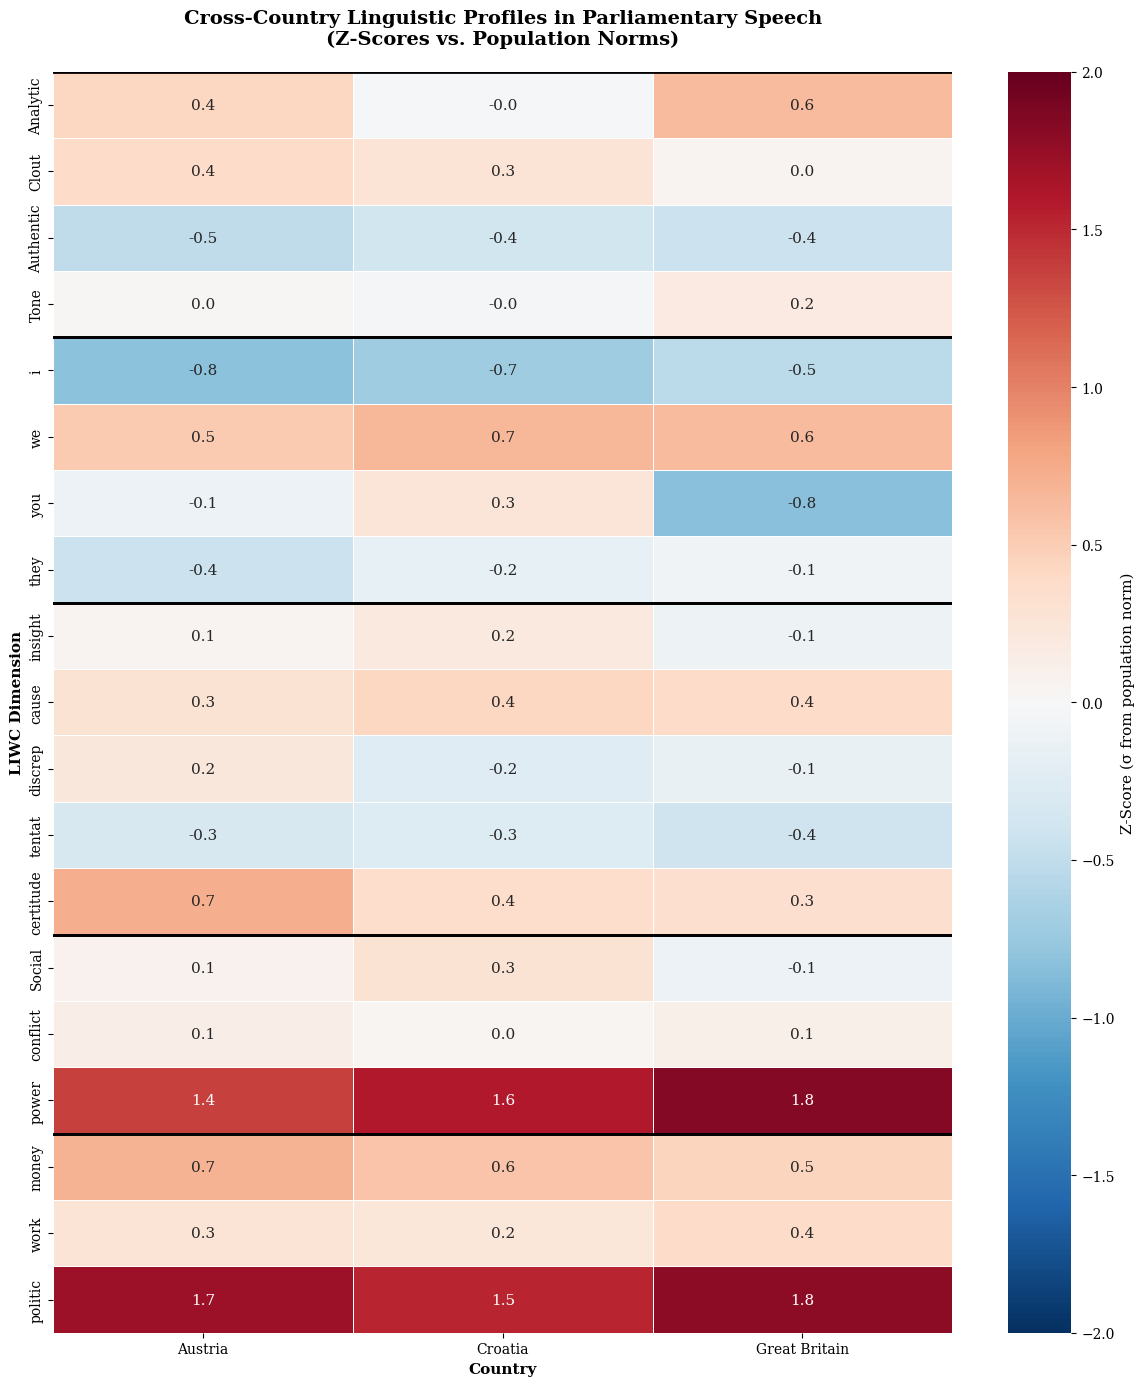

In [ ]:
# Cross-country comparison focusing on core political dimensions
def create_political_discourse_heatmap(data, benchmarks):
    """Heatmap showing cross-country differences in key political discourse dimensions."""
    core_dimensions = {
        'Summary Variables': ['Analytic', 'Clout', 'Authentic', 'Tone'],
        'Personal Pronouns': ['i', 'we', 'you', 'they'],
        'Cognitive Processes': ['insight', 'cause', 'discrep', 'tentat', 'certitude'],
        'Social & Conflict': ['Social', 'conflict', 'power'],
        'Policy Domains': ['money', 'work', 'politic']
    }
    
    all_dims = [d for dims in core_dimensions.values() for d in dims]
    
    # Calculate z-scores
    country_means = data.groupby('Country')[all_dims].mean()
    benchmark_lookup = benchmarks.set_index('Dimension')
    benchmark_means = benchmark_lookup.loc[all_dims, 'Mean']
    benchmark_stds = benchmark_lookup.loc[all_dims, 'Std']
    z_scores = (country_means - benchmark_means) / benchmark_stds
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 14))
    
    # Add section separators
    section_boundaries = []
    current_pos = 0
    for section, dims in core_dimensions.items():
        section_boundaries.append((current_pos, len(dims), section))
        current_pos += len(dims)
    
    sns.heatmap(z_scores.T, annot=True, fmt=".1f", cmap="RdBu_r", center=0, 
                cbar_kws={'label': 'Z-Score (σ from population norm)'},
                vmin=-2, vmax=2, linewidths=0.5, ax=ax)
    
    for pos, length, label in section_boundaries:
        ax.axhline(y=pos, color='black', linewidth=2)
        if pos + length < len(all_dims):
            ax.axhline(y=pos + length, color='black', linewidth=2)
    
    ax.set_title("Cross-Country Linguistic Profiles in Parliamentary Speech\n(Z-Scores vs. Population Norms)", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel("LIWC Dimension", fontweight='bold')
    ax.set_xlabel("Country", fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'fig_cross_country_profiles.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    
    return z_scores

z_scores_country = create_political_discourse_heatmap(LIWC_ALL, LIWC_benchmarks)

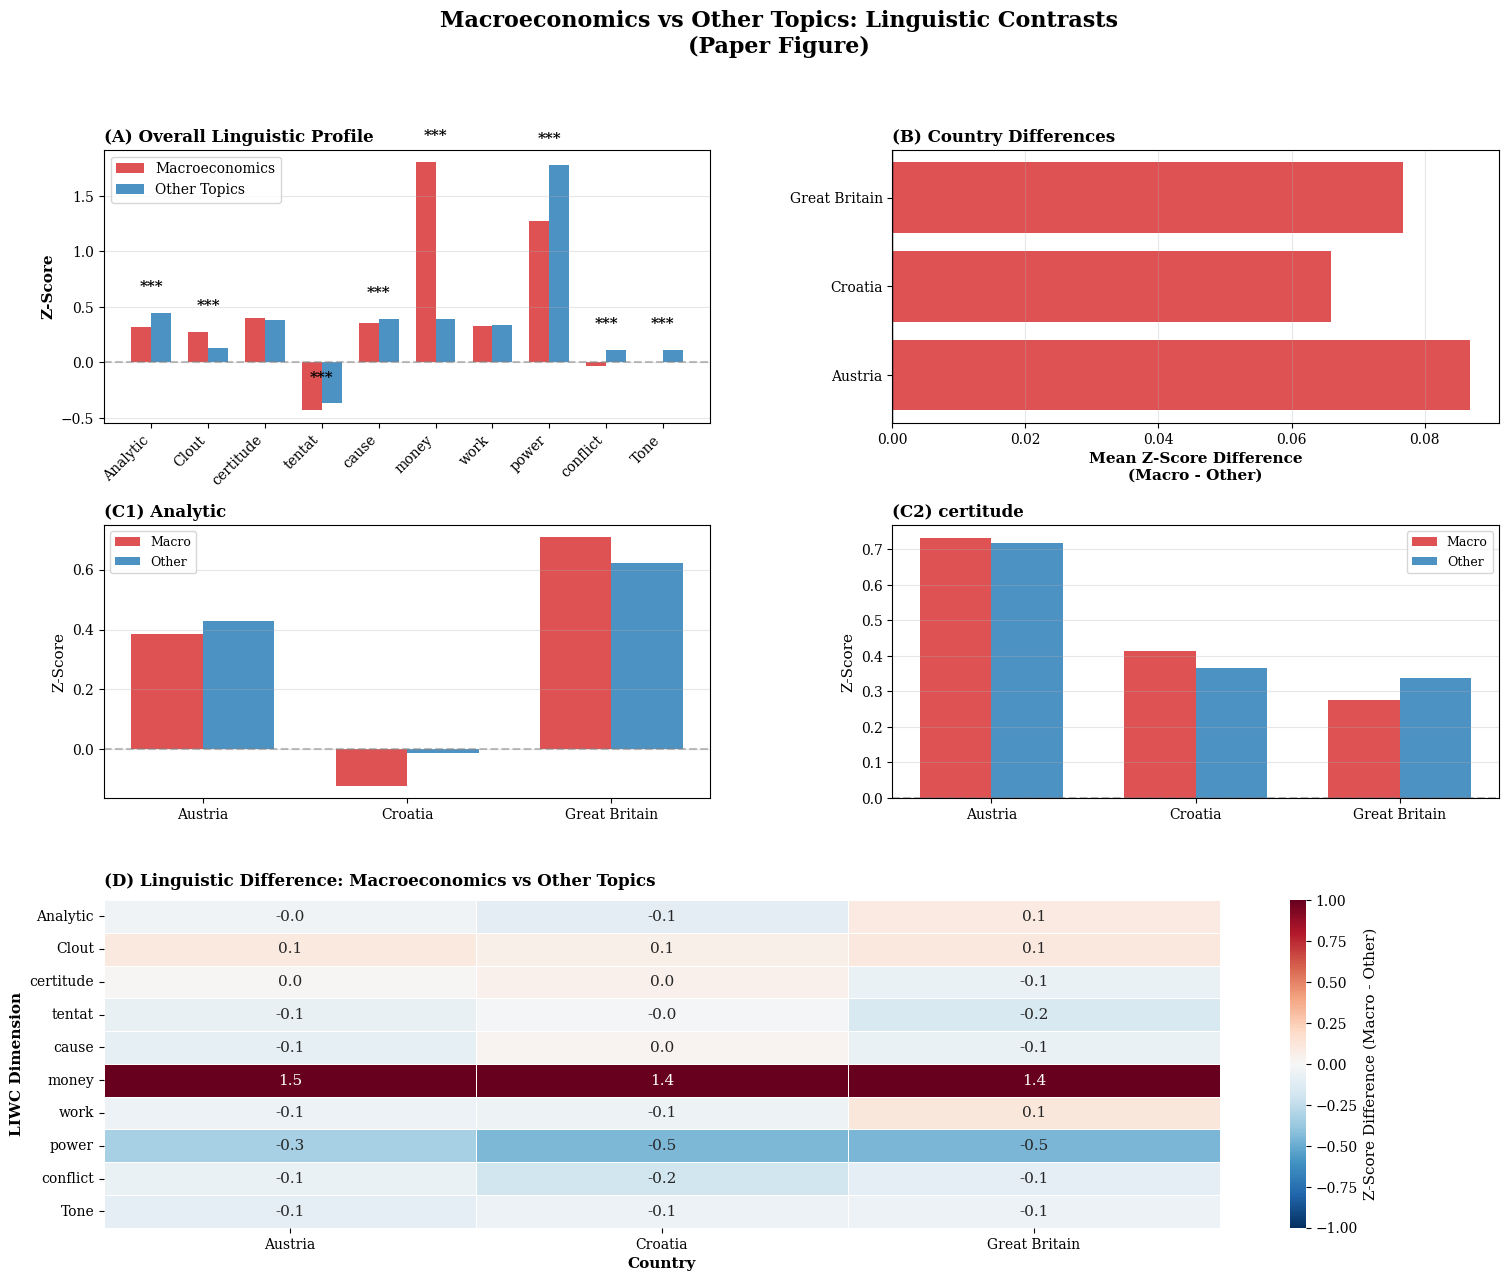

In [ ]:
# Macroeconomics Analysis
LIWC_ALL['Topic_Group'] = LIWC_ALL['Our_Topic'].apply(
    lambda x: 'Macroeconomics' if x == 'Macroeconomics' else 'Other Topics'
)

macro_dims = ['Analytic', 'Clout', 'certitude', 'tentat', 'cause',
             'money', 'work', 'power', 'conflict', 'Tone']

# Z-score normalization
benchmark_lookup = LIWC_benchmarks.set_index('Dimension')
macro_z_data = LIWC_ALL.copy()

for dim in macro_dims:
    benchmark_mean = benchmark_lookup.loc[dim, 'Mean']
    benchmark_std = benchmark_lookup.loc[dim, 'Std']
    macro_z_data[f'{dim}_z'] = (LIWC_ALL[dim] - benchmark_mean) / benchmark_std

# Create figure
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3, height_ratios=[1, 1, 1.2])

fig.suptitle('Macroeconomics vs Other Topics: Linguistic Contrasts\n(Paper Figure)', 
            fontsize=16, fontweight='bold')

# PANEL 1: Overall comparison
ax1 = fig.add_subplot(gs[0, 0])
overall_means = macro_z_data.groupby('Topic_Group')[[f'{d}_z' for d in macro_dims]].mean()
overall_means.columns = [col.replace('_z', '') for col in overall_means.columns]

x = np.arange(len(overall_means.columns))
width = 0.35
ax1.bar(x - width/2, overall_means.loc['Macroeconomics'], width, 
       label='Macroeconomics', alpha=0.8, color='#d62728')
ax1.bar(x + width/2, overall_means.loc['Other Topics'], width, 
       label='Other Topics', alpha=0.8, color='#1f77b4')

ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_ylabel('Z-Score', fontweight='bold')
ax1.set_title('(A) Overall Linguistic Profile', fontweight='bold', loc='left')
ax1.set_xticks(x)
ax1.set_xticklabels(overall_means.columns, rotation=45, ha='right')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3, axis='y')

# Add significance stars
for i, dim in enumerate(macro_dims):
    macro_vals = LIWC_ALL[LIWC_ALL['Topic_Group'] == 'Macroeconomics'][dim].dropna()
    other_vals = LIWC_ALL[LIWC_ALL['Topic_Group'] == 'Other Topics'][dim].dropna()
    _, p = ttest_ind(macro_vals, other_vals)
    if p < 0.001:
        y_pos = max(overall_means.iloc[:, i]) + 0.2
        ax1.text(i, y_pos, '***', ha='center', fontweight='bold')

# PANEL 2: Country-specific differences
ax2 = fig.add_subplot(gs[0, 1])
country_macro_diff = []
countries = sorted(macro_z_data['Country'].unique())

for country in countries:
    c_data = macro_z_data[macro_z_data['Country'] == country]
    macro_mean = c_data[c_data['Topic_Group'] == 'Macroeconomics'][[f'{d}_z' for d in macro_dims]].mean().mean()
    other_mean = c_data[c_data['Topic_Group'] == 'Other Topics'][[f'{d}_z' for d in macro_dims]].mean().mean()
    country_macro_diff.append(macro_mean - other_mean)

ax2.barh(countries, country_macro_diff, 
       color=['#d62728' if x > 0 else '#1f77b4' for x in country_macro_diff],
       alpha=0.8)
ax2.axvline(x=0, color='black', linewidth=1)
ax2.set_xlabel('Mean Z-Score Difference\n(Macro - Other)', fontweight='bold')
ax2.set_title('(B) Country Differences', fontweight='bold', loc='left')
ax2.grid(True, alpha=0.3, axis='x')

# PANEL 3: Selected dimensions by country
key_dims_display = ['Analytic', 'certitude', 'money', 'work']

country_topic_data = []
for country in countries:
    for topic_group in ['Macroeconomics', 'Other Topics']:
        row_data = [country, topic_group]
        for dim in key_dims_display:
            mean_val = macro_z_data[(macro_z_data['Country'] == country) & 
                                   (macro_z_data['Topic_Group'] == topic_group)][f'{dim}_z'].mean()
            row_data.append(mean_val)
        country_topic_data.append(row_data)

df_plot = pd.DataFrame(country_topic_data, 
                      columns=['Country', 'Topic'] + key_dims_display)

x_pos = np.arange(len(countries))
width = 0.35

for i, dim in enumerate(key_dims_display[:2]):
    ax_sub = fig.add_subplot(gs[1, i])
        
    macro_vals = df_plot[df_plot['Topic'] == 'Macroeconomics'][dim].values
    other_vals = df_plot[df_plot['Topic'] == 'Other Topics'][dim].values
    
    ax_sub.bar(x_pos - width/2, macro_vals, width, label='Macro', color='#d62728', alpha=0.8)
    ax_sub.bar(x_pos + width/2, other_vals, width, label='Other', color='#1f77b4', alpha=0.8)
    ax_sub.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax_sub.set_xticks(x_pos)
    ax_sub.set_xticklabels(countries, rotation=0)
    ax_sub.set_ylabel('Z-Score')
    ax_sub.set_title(f'(C{i+1}) {dim}', fontweight='bold', loc='left')
    ax_sub.legend(loc='best', fontsize=9)
    ax_sub.grid(True, alpha=0.3, axis='y')

# PANEL 4: Heatmap showing DIFFERENCE (Macro - Other)
ax4 = fig.add_subplot(gs[2, :])

heatmap_data = macro_z_data.groupby(['Country', 'Topic_Group'])[[f'{d}_z' for d in macro_dims]].mean()
heatmap_data.columns = [col.replace('_z', '') for col in heatmap_data.columns]

# Calculate differences (Macro - Other) for each country
countries = sorted(macro_z_data['Country'].unique())
difference_data = []
row_labels = []

for country in countries:
    macro_vals = heatmap_data.loc[(country, 'Macroeconomics'), :].values
    other_vals = heatmap_data.loc[(country, 'Other Topics'), :].values
    difference = macro_vals - other_vals
    difference_data.append(difference)
    row_labels.append(country)

heatmap_display_df = pd.DataFrame(difference_data, index=row_labels, columns=heatmap_data.columns)

sns.heatmap(heatmap_display_df.T, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
           ax=ax4, cbar_kws={'label': 'Z-Score Difference (Macro - Other)'}, 
           vmin=-1.0, vmax=1.0, linewidths=0.5)
ax4.set_title('(D) Linguistic Difference: Macroeconomics vs Other Topics', 
             fontweight='bold', loc='left', pad=10)
ax4.set_xlabel('Country', fontweight='bold')
ax4.set_ylabel('LIWC Dimension', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'fig_macroeconomics_focal_analysis.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'Speaker_age'

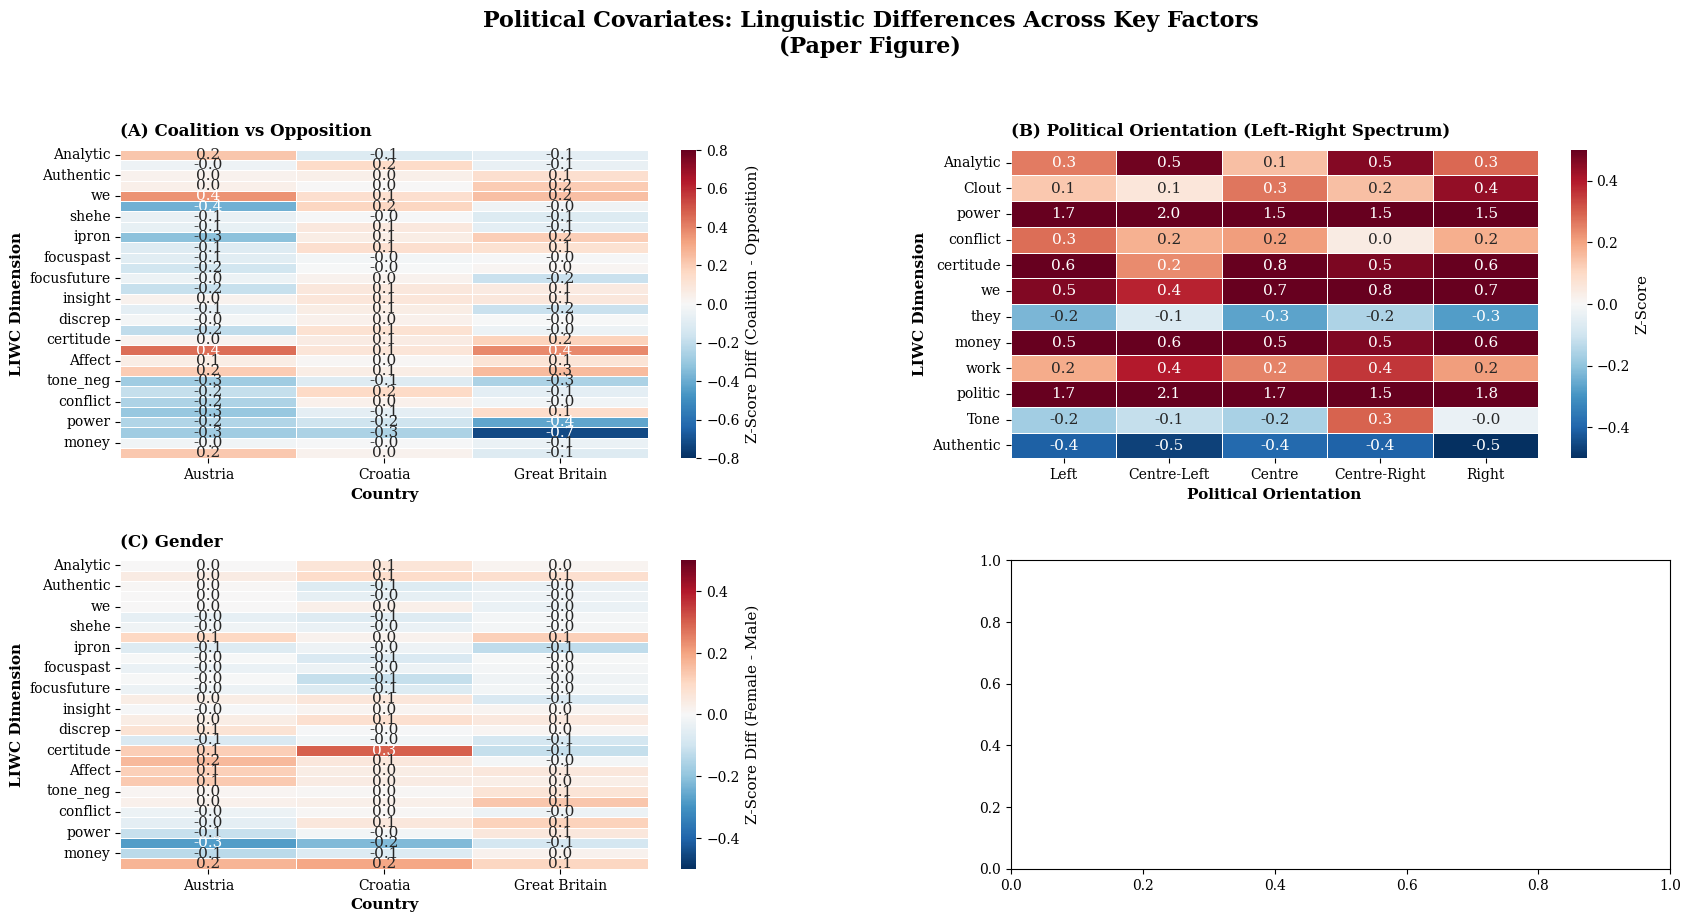

In [ ]:
# Political Covariates Analysis
# Use ALL key LIWC dimensions for comprehensive analysis
covariate_dims = KEY_LIWC_DIMENSIONS

# Z-score normalize
benchmark_lookup = LIWC_benchmarks.set_index('Dimension')
covariate_data = LIWC_ALL.copy()

for dim in covariate_dims:
    benchmark_mean = benchmark_lookup.loc[dim, 'Mean']
    benchmark_std = benchmark_lookup.loc[dim, 'Std']
    covariate_data[f'{dim}_z'] = (LIWC_ALL[dim] - benchmark_mean) / benchmark_std

# Create figure
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.35, height_ratios=[1.2, 1.2, 1])

fig.suptitle('Political Covariates: Linguistic Differences Across Key Factors\n(Paper Figure)', 
            fontsize=16, fontweight='bold')

# PANEL 1: Party Status DIFFERENCE (Coalition - Opposition) - HEATMAP
ax1 = fig.add_subplot(gs[0, 0])

coalition_data = covariate_data[covariate_data['Party_status'].isin(['Coalition', 'Opposition'])]
status_by_country = coalition_data.groupby(['Country', 'Party_status'])[[f'{d}_z' for d in covariate_dims]].mean()
status_by_country.columns = [c.replace('_z', '') for c in status_by_country.columns]

# Calculate differences for each country
countries = sorted(coalition_data['Country'].unique())
status_diff_data = []
for country in countries:
    coal_vals = status_by_country.loc[(country, 'Coalition'), :].values
    opp_vals = status_by_country.loc[(country, 'Opposition'), :].values
    difference = coal_vals - opp_vals
    status_diff_data.append(difference)

status_diff_df = pd.DataFrame(status_diff_data, index=countries, columns=status_by_country.columns)

sns.heatmap(status_diff_df.T, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
           ax=ax1, cbar_kws={'label': 'Z-Score Diff (Coalition - Opposition)'}, 
           vmin=-0.8, vmax=0.8, linewidths=0.5)
ax1.set_title('(A) Coalition vs Opposition', fontweight='bold', loc='left', pad=10)
ax1.set_xlabel('Country', fontweight='bold')
ax1.set_ylabel('LIWC Dimension', fontweight='bold')

# PANEL 2: Political Orientation (Left-Right Spectrum) - HEATMAP
ax2 = fig.add_subplot(gs[0, 1])

orientation_data = covariate_data[(covariate_data['Party_orientation'].notna()) & 
                                  (covariate_data['Party_orientation'] != '-') &
                                  (~covariate_data['Party_orientation'].str.contains(';', na=False))]

orientation_mapping = {
    'Left': 'Left', 'Centre-left to left': 'Left',
    'Centre-left': 'Centre-Left', 'Centre to centre-left': 'Centre-Left',
    'Centre': 'Centre',
    'Centre to centre-right': 'Centre-Right', 'Centre-right': 'Centre-Right',
    'Centre-right to right': 'Right', 'Right': 'Right',
    'Right to far-right': 'Right', 'Far-right': 'Right'
}

orientation_data['Orientation_Simple'] = orientation_data['Party_orientation'].map(orientation_mapping)
orientation_counts = orientation_data['Orientation_Simple'].value_counts()
significant_orientations = orientation_counts[orientation_counts >= 1000].index
orientation_filtered = orientation_data[orientation_data['Orientation_Simple'].isin(significant_orientations)]

# Select subset of dimensions for orientation plot
key_political_dims = ['Analytic', 'Clout', 'power', 'conflict', 'certitude', 'we', 'they', 
                      'money', 'work', 'politic', 'Tone', 'Authentic']

orient_means = orientation_filtered.groupby('Orientation_Simple')[[f'{d}_z' for d in key_political_dims]].mean()
orient_means.columns = [c.replace('_z', '') for c in orient_means.columns]

spectrum_order = ['Left', 'Centre-Left', 'Centre', 'Centre-Right', 'Right']
orient_means = orient_means.reindex([o for o in spectrum_order if o in orient_means.index])

sns.heatmap(orient_means.T, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
           ax=ax2, cbar_kws={'label': 'Z-Score'}, vmin=-0.5, vmax=0.5, linewidths=0.5)
ax2.set_title('(B) Political Orientation (Left-Right Spectrum)', fontweight='bold', loc='left', pad=10)
ax2.set_xlabel('Political Orientation', fontweight='bold')
ax2.set_ylabel('LIWC Dimension', fontweight='bold')

# PANEL 3: Gender DIFFERENCE (Female - Male) - HEATMAP by country
ax3 = fig.add_subplot(gs[1, 0])

gender_data = covariate_data[covariate_data['Speaker_gender'].isin(['M', 'F'])]
gender_by_country = gender_data.groupby(['Country', 'Speaker_gender'])[[f'{d}_z' for d in covariate_dims]].mean()
gender_by_country.columns = [c.replace('_z', '') for c in gender_by_country.columns]

# Calculate differences for each country
gender_diff_data = []
for country in countries:
    female_vals = gender_by_country.loc[(country, 'F'), :].values
    male_vals = gender_by_country.loc[(country, 'M'), :].values
    difference = female_vals - male_vals
    gender_diff_data.append(difference)

gender_diff_df = pd.DataFrame(gender_diff_data, index=countries, columns=gender_by_country.columns)

sns.heatmap(gender_diff_df.T, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
           ax=ax3, cbar_kws={'label': 'Z-Score Diff (Female - Male)'}, 
           vmin=-0.5, vmax=0.5, linewidths=0.5)
ax3.set_title('(C) Gender', fontweight='bold', loc='left', pad=10)
ax3.set_xlabel('Country', fontweight='bold')
ax3.set_ylabel('LIWC Dimension', fontweight='bold')

# PANEL 4: Age (Linear trend across age groups) - HEATMAP
ax4 = fig.add_subplot(gs[1, 1])

age_data = covariate_data[(covariate_data['Speaker_age'] >= 20) & 
                         (covariate_data['Speaker_age'] <= 80)]

age_data['Age_Group'] = pd.cut(age_data['Speaker_age'], 
                               bins=[20, 35, 50, 65, 80],
                               labels=['20-35', '36-50', '51-65', '66-80'])

# Select subset of dimensions for age
age_dims = ['Analytic', 'Clout', 'certitude', 'tentat', 'we', 'i', 'you', 
            'power', 'Authentic', 'Tone', 'conflict', 'Social']

age_means = age_data.groupby('Age_Group')[[f'{d}_z' for d in age_dims]].mean()
age_means.columns = [c.replace('_z', '') for c in age_means.columns]

sns.heatmap(age_means.T, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
           ax=ax4, cbar_kws={'label': 'Z-Score'}, vmin=-0.4, vmax=0.4, linewidths=0.5)
ax4.set_title('(D) Age Groups', fontweight='bold', loc='left', pad=10)
ax4.set_xlabel('Age Group', fontweight='bold')
ax4.set_ylabel('LIWC Dimension', fontweight='bold')

# PANEL 5: Party Status × Gender Interaction - HEATMAP of differences
ax5 = fig.add_subplot(gs[2, :])

interact_data = covariate_data[
    (covariate_data['Speaker_gender'].isin(['M', 'F'])) &
    (covariate_data['Party_status'].isin(['Coalition', 'Opposition']))
]

# Select subset for interaction
interact_dims = ['power', 'conflict', 'Clout', 'certitude', 'we', 'they', 
                'Analytic', 'money', 'work', 'Tone', 'Authentic', 'Social']

interact_means = interact_data.groupby(['Party_status', 'Speaker_gender'])[[f'{d}_z' for d in interact_dims]].mean()
interact_means.columns = [c.replace('_z', '') for c in interact_means.columns]

# Create matrix: rows are dimensions, columns are 4 combinations
interact_labels = []
interact_vals = []
for status in ['Coalition', 'Opposition']:
    for gender in ['F', 'M']:
        interact_labels.append(f'{status[:4]}-{gender}')
        interact_vals.append(interact_means.loc[(status, gender), :].values)

interact_df = pd.DataFrame(interact_vals, index=interact_labels, columns=interact_means.columns)

sns.heatmap(interact_df.T, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
           ax=ax5, cbar_kws={'label': 'Z-Score'}, vmin=-0.6, vmax=0.6, linewidths=0.5)
ax5.set_title('(E) Party Status × Gender Interaction', fontweight='bold', loc='left', pad=10)
ax5.set_xlabel('Group', fontweight='bold')
ax5.set_ylabel('LIWC Dimension', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'fig_political_covariates_comprehensive.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
LIWC_ALL.head(2)

,Text_ID,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,Lang,Speaker_role,Speaker_MP,Speaker_minister,Speaker_party,Speaker_party_name,Party_status,Party_orientation,Speaker_ID,Speaker_name,Speaker_gender,Speaker_birth,ParlaCAP,Text,Text_native_language,Speech_Embeddings_english,Speech_Embeddings_native_language,Segment_ID_english,Segment_ID_german,segment_embeddings_english,segment_embeddings_native_language,Segment_Topic_AT_english,my_topic_en_gmm,my_topic_de_gmm,my_topic_en_hdbscan,my_topic_de_hdbscan,Our_Topic,Segment,WC,Analytic,Clout,Authentic,Tone,WPS,BigWords,Dic,Linguistic,function,pronoun,ppron,i,we,you,shehe,they,ipron,det,article,number,prep,auxverb,adverb,conj,negate,verb,adj,quantity,Drives,affiliation,achieve,power,Cognition,allnone,cogproc,insight,cause,discrep,tentat,certitude,differ,memory,Affect,tone_pos,tone_neg,emotion,emo_pos,emo_neg,emo_anx,emo_anger,emo_sad,swear,Social,socbehav,prosocial,polite,conflict,moral,comm,socrefs,family,friend,female,male,Culture,politic,ethnicity,tech,Lifestyle,leisure,home,work,money,relig,Physical,health,illness,wellness,mental,substances,sexual,food,death,need,want,acquire,lack,fulfill,fatigue,reward,risk,curiosity,allure,Perception,attention,motion,space,visual,auditory,feeling,time,focuspast,focuspresent,focusfuture,Conversation,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,QMark,Exclam,Apostro,OtherP,Emoji,Country,Segment_ID_croatian,Segment_Topic_HR_english,my_topic_hr_gmm,True_label,my_topic_hr_hdbscan,speech_length,Word_Count,Speech_Embeddings,Segment_ID,Segment_Topic_GB_english,my_topic_gmm,my_topic_hdbscan,Year,Topic_Group
3,ParlaMint-AT-en_1996-01-15-020-XX-NRSITZ-00001,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7...,"Sitting Number 1, Legislative period XX, Monda...",1996-01-15,Lower house,Legislative period XX,-,-,Sitting 1,-,Reference,English,Regular,MP,notMinister,SPÖ,parliamentary group of the Social Democratic P...,Coalition,Centre-left,PAD_01153,"Parfuss, Ludmilla",F,1942,Other,"""They will be vowed unbreakable fidelity of th...","""Sie werden geloben unverbrüchliche Treue der ...","[-0.04623, 0.0174, -0.05997, -0.02737, -0.0221...","[-0.03482, 0.0377, -0.05243, -0.02045, -0.0349...",ParlaMint-AT-en_1996-01-15-020-XX-NRSITZ-00001...,ParlaMint-AT-en_1996-01-15-020-XX-NRSITZ-00001...,"[-0.0050221486, -0.0021069436, -0.04859738, 0....","[-0.0060872454, 0.0067266175, -0.045665205, 0....",117.0,Other,Other,Agriculture,Other,Agriculture,1,657,90.53,47.28,1.00,22.11,29.86,27.85,15.83,11.72,5.18,0.76,0.76,0.30,0.00,0.15,0.15,0.15,0.00,1.98,1.37,0.00,1.52,0.46,0.00,0.91,0.00,5.94,1.22,0.46,1.67,0.61,0.30,0.76,6.09,0.15,5.63,0.00,5.18,0.00,0.30,0.00,0.15,0.0,0.76,0.46,0.30,0.30,0.15,0.15,0.0,0.0,0.15,0.0,2.28,0.91,0.15,0.15,0.00,0.00,0.46,1.52,0.15,0.15,0.30,0.3,0.46,0.15,0.15,0.15,0.30,0.00,0.00,0.30,0.00,0.0,0.46,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.00,0.00,0.00,0.15,0.0,0.00,0.0,0.00,0.61,0.91,0.46,0.15,0.15,0.46,0.15,0.0,0.30,0.00,0.15,0.30,0.0,0.0,0.0,0.0,0.0,59.97,18.57,15.22,0.0,0.00,0.00,26.18,0,Austria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996,Other Topics
7,ParlaMint-AT-en_1996-01-15-020-XX-NRSITZ-00001,ParlaMint-AT_1996-01-15-020-XX-NRSITZ-00001_d7...,"Sitting Number 1, Legislative period XX, Monda...",1996-01-15,Lower house,Legislative period XX,-,-,Sitting 1,-,Reference,English,Regular,MP,notMinister,SPÖ,parliamentary group of the Social Democratic P...,Coalition,Centre-left,PAD_00930,"Kostelka, Peter",M,1946,Government Operations,Mr President. Ladies and gentlemen! High house...,Herr Präsident! Meine sehr geehrten Damen und ...,"[-0.01517, 0.003448, -0.0545, 0.03384, 0.00026...","[-0.01411, 0.01264, -0.04904, 0.03995, -0.0002...",ParlaMint-AT-en_1996-01-15-020-XX-NRSITZ-00001...,ParlaMint-AT-en_1996-01-15-020-XX-NRSITZ-00001...,"[-0.0050221486, -0.0021069436, -0.04859738, 0....","[-0.0060872454, 0.0067266175, -0.045665205, 0....",117.0,Other,Other,Other,Labor,Labor,1,816,79.10,61.18,56.31,62.67,18.98,21.57,93.01,70.5

TEMPORAL EVOLUTION ANALYSIS


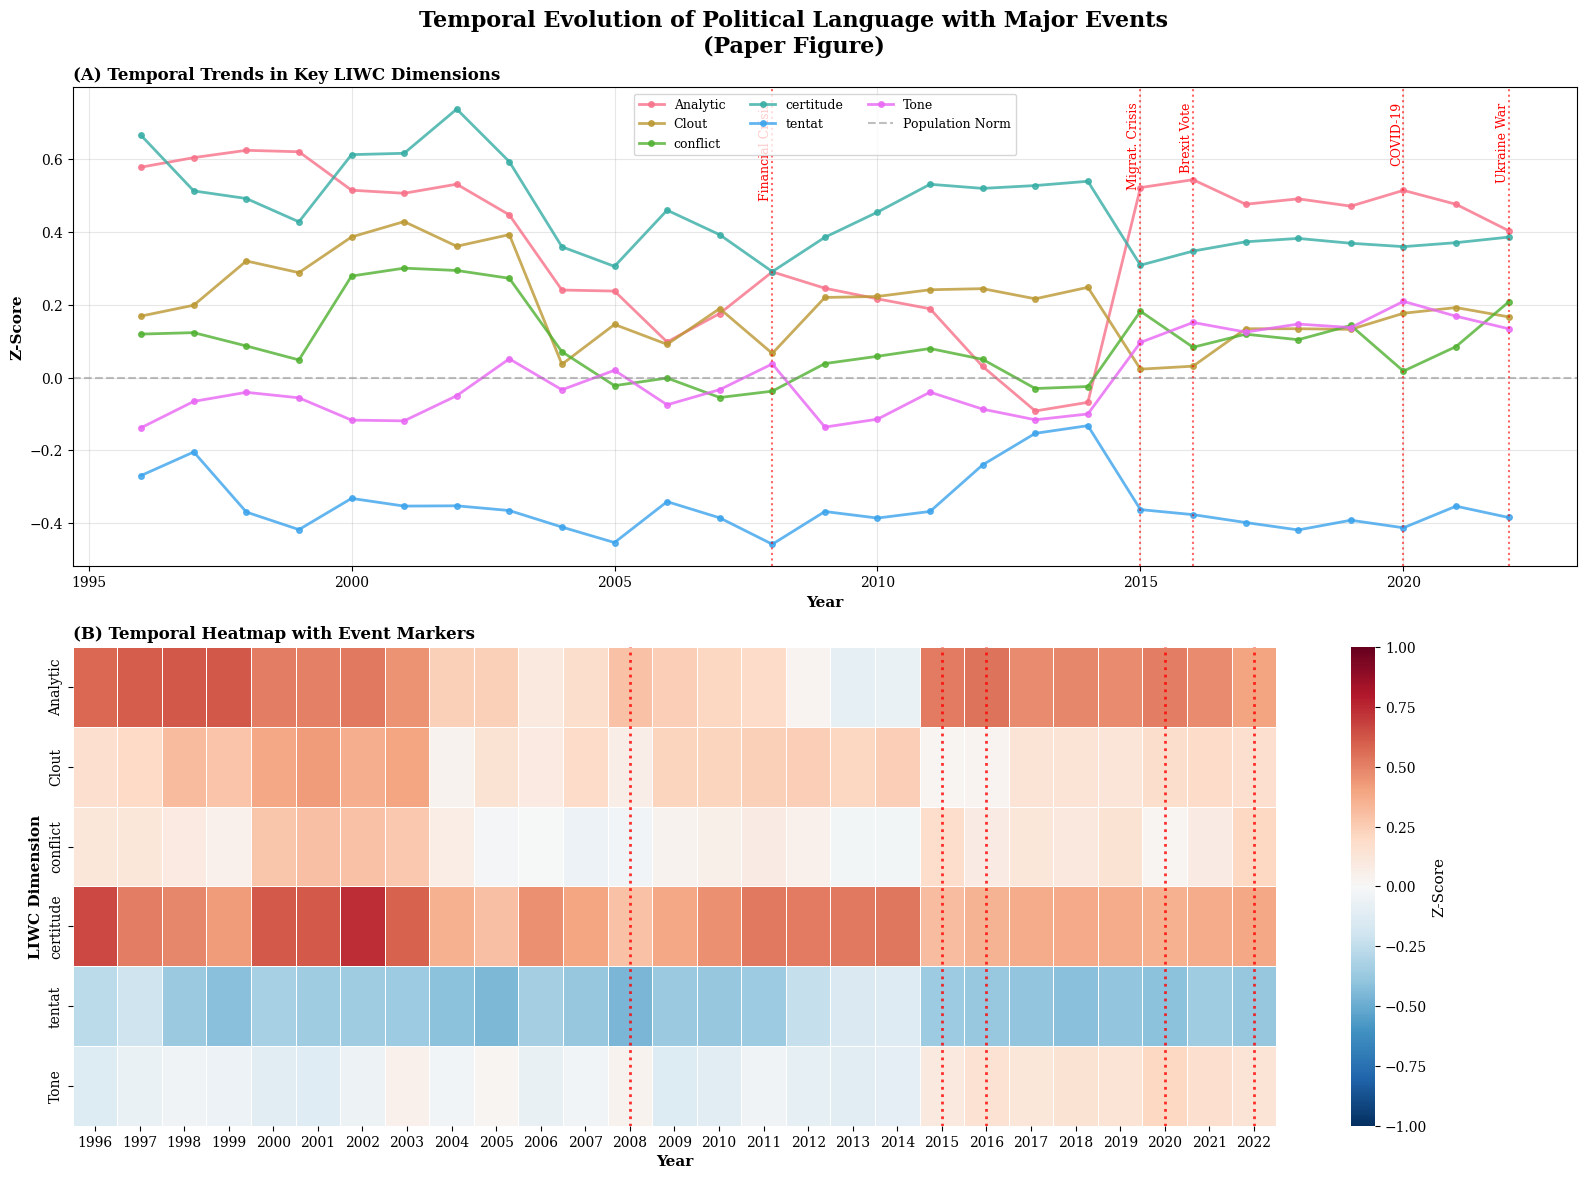


Temporal Trends (Pearson correlation with Year):
  Analytic       : r=+nan, p=nan 
  Clout          : r=+nan, p=nan 
  conflict       : r=+0.004, p=0.0003 ***
  Analytic       : r=+nan, p=nan 
  Clout          : r=+nan, p=nan 
  conflict       : r=+0.004, p=0.0003 ***
  certitude      : r=-0.008, p=0.0000 ***
  tentat         : r=-0.007, p=0.0000 ***
  Tone           : r=+nan, p=nan 
  certitude      : r=-0.008, p=0.0000 ***
  tentat         : r=-0.007, p=0.0000 ***
  Tone           : r=+nan, p=nan 


In [ ]:
# Temporal Analysis with Event Annotations
temporal_data = LIWC_ALL[LIWC_ALL['Year'].notna()].copy()
year_counts = temporal_data['Year'].value_counts()
sufficient_years = year_counts[year_counts >= 20].index
temporal_data = temporal_data[temporal_data['Year'].isin(sufficient_years)]

temporal_dims = ['Analytic', 'Clout', 'conflict', 'certitude', 'tentat', 'Tone']

# Z-score normalize
benchmark_lookup = LIWC_benchmarks.set_index('Dimension')
temporal_z_data = temporal_data.copy()

for dim in temporal_dims:
    benchmark_mean = benchmark_lookup.loc[dim, 'Mean']
    benchmark_std = benchmark_lookup.loc[dim, 'Std']
    temporal_z_data[f'{dim}_z'] = (temporal_data[dim] - benchmark_mean) / benchmark_std

# Calculate yearly means
yearly_data = temporal_z_data.groupby('Year')[[f'{d}_z' for d in temporal_dims]].mean()
yearly_data.columns = [c.replace('_z', '') for c in yearly_data.columns]

# Define major events
events = {
    2008: 'Financial Crisis',
    2015: 'Migrat. Crisis',
    2016: 'Brexit Vote',
    2020: 'COVID-19',
}

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle('Temporal Evolution of Political Language with Major Events\n(Paper Figure)', 
            fontsize=16, fontweight='bold')

# Plot 1: Line plot
for dim in yearly_data.columns:
    ax1.plot(yearly_data.index, yearly_data[dim], 
            marker='o', linewidth=2, label=dim, alpha=0.8, markersize=4)

ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Population Norm')

for year, event in events.items():
    if year in yearly_data.index:
        ax1.axvline(x=year, color='red', linestyle=':', alpha=0.6, linewidth=1.5)
        ax1.text(year, ax1.get_ylim()[1] * 0.95, event, 
                rotation=90, va='top', ha='right', fontsize=9, color='red')

ax1.set_xlabel('Year', fontweight='bold')
ax1.set_ylabel('Z-Score', fontweight='bold')
ax1.set_title('(A) Temporal Trends in Key LIWC Dimensions', fontweight='bold', loc='left')
ax1.legend(loc='best', ncol=3, fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Heatmap
sns.heatmap(yearly_data.T, cmap='RdBu_r', center=0, ax=ax2,
            cbar_kws={'label': 'Z-Score'}, vmin=-1, vmax=1, 
            linewidths=0.5, annot=False)

for year, event in events.items():
    if year in yearly_data.index:
        year_idx = list(yearly_data.index).index(year)
        ax2.axvline(x=year_idx + 0.5, color='red', linestyle=':', linewidth=2, alpha=0.8)

ax2.set_xlabel('Year', fontweight='bold')
ax2.set_ylabel('LIWC Dimension', fontweight='bold')
ax2.set_title('(B) Temporal Heatmap with Event Markers', fontweight='bold', loc='left')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'fig_temporal_evolution_events.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

TOPIC PREVALENCE OVER TIME ANALYSIS

Country temporal coverage:

Country temporal coverage:
  Austria: 1996–2022
  Austria: 1996–2022
  Croatia: 2003–2022
  Croatia: 2003–2022
  Great Britain: 2015–2022
  Great Britain: 2015–2022


TOPIC PREVALENCE OVER TIME ANALYSIS

Country temporal coverage:

Country temporal coverage:
  Austria: 1996–2022
  Austria: 1996–2022
  Croatia: 2003–2022
  Croatia: 2003–2022
  Great Britain: 2015–2022
  Great Britain: 2015–2022


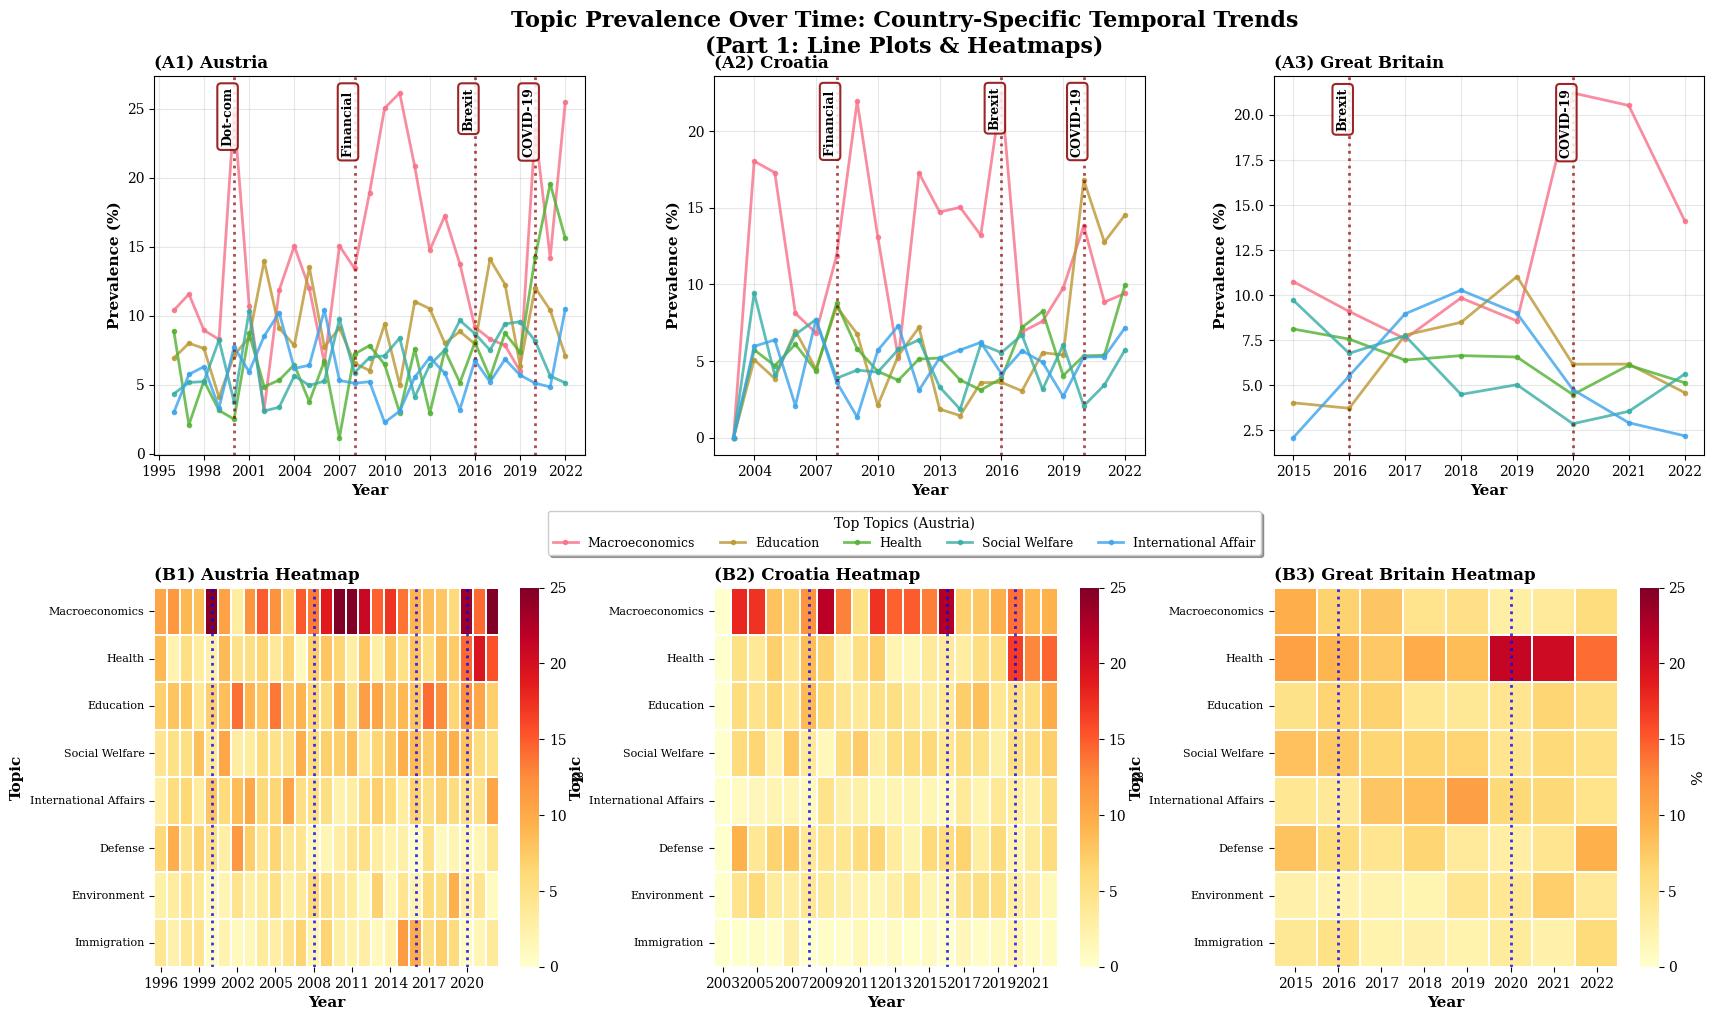

TOPIC PREVALENCE OVER TIME ANALYSIS

Country temporal coverage:

Country temporal coverage:
  Austria: 1996–2022
  Austria: 1996–2022
  Croatia: 2003–2022
  Croatia: 2003–2022
  Great Britain: 2015–2022
  Great Britain: 2015–2022


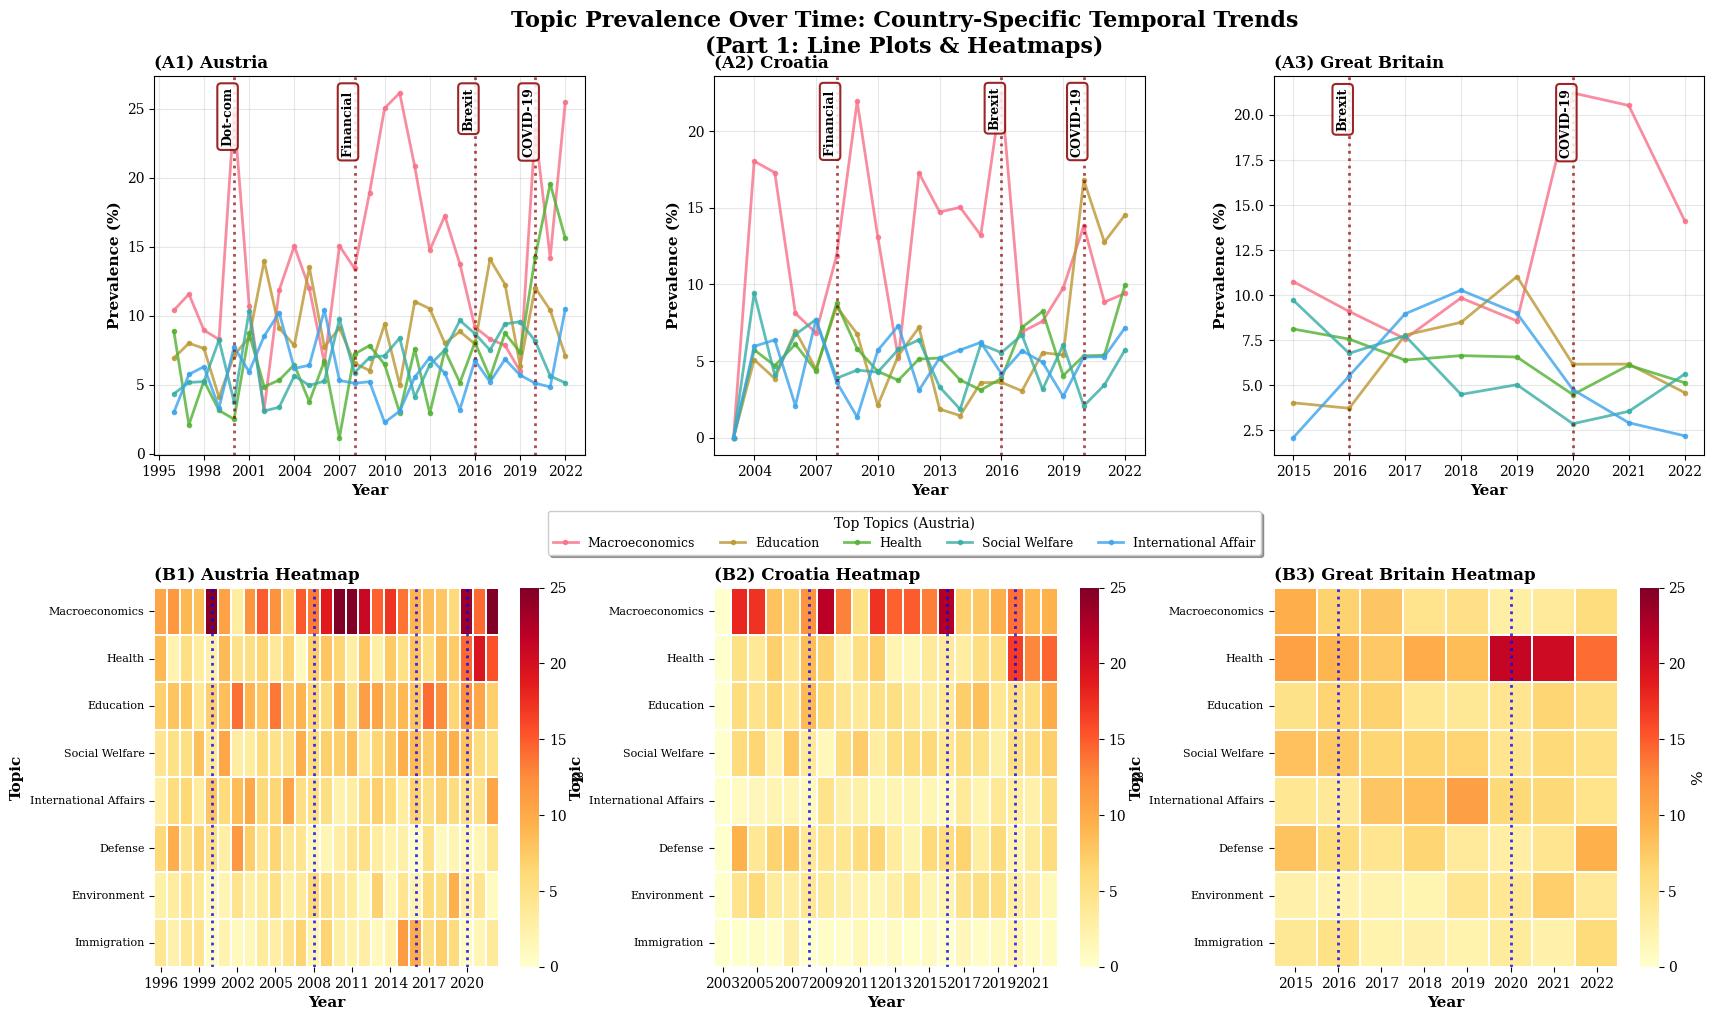

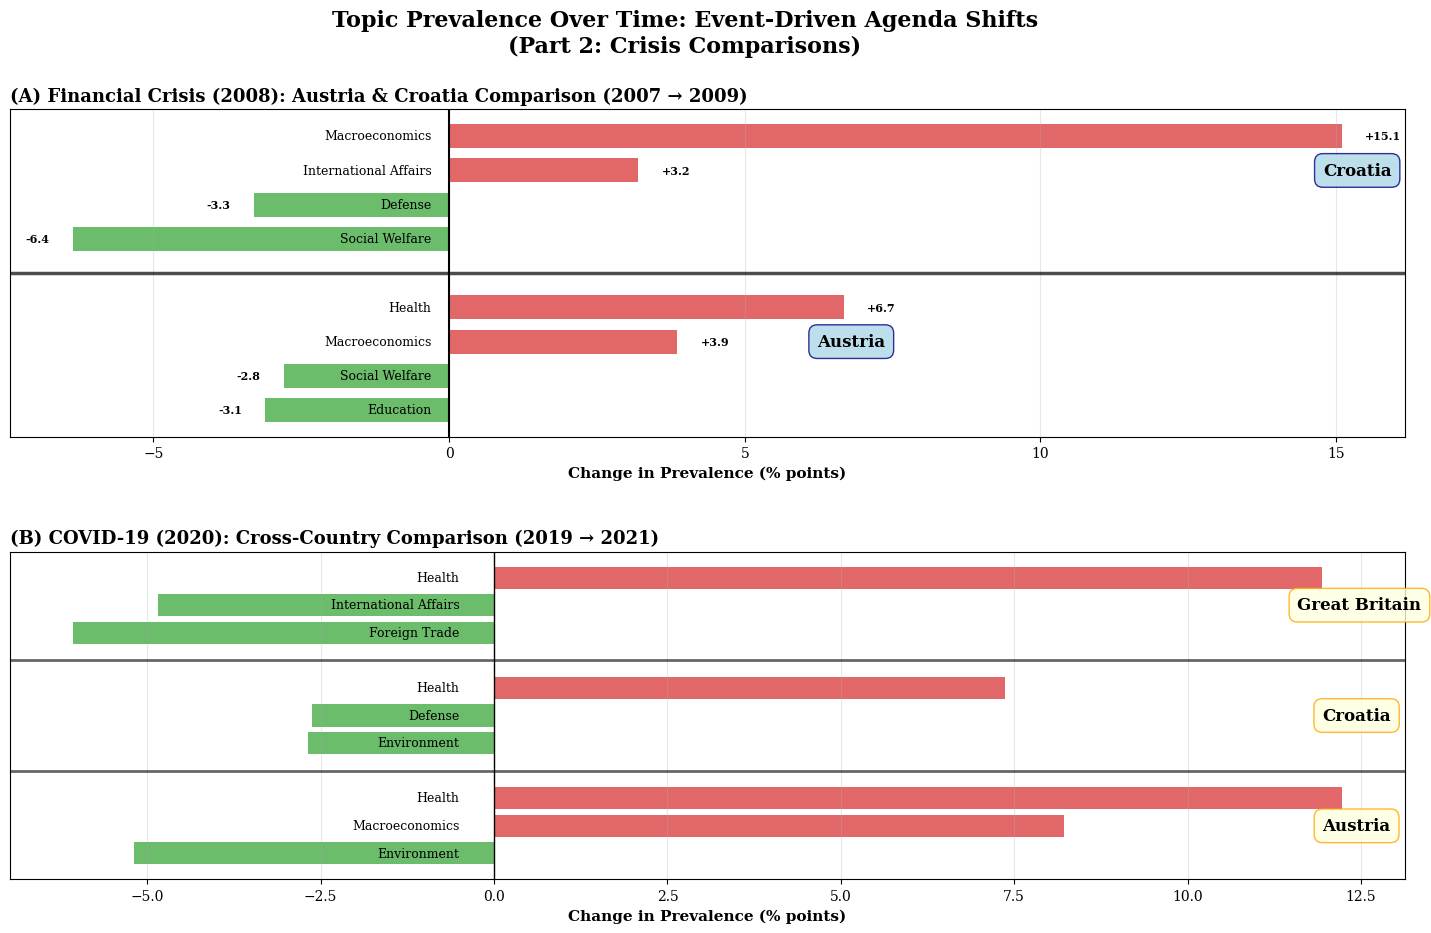

TOPIC PREVALENCE OVER TIME ANALYSIS

Country temporal coverage:

Country temporal coverage:
  Austria: 1996–2022
  Austria: 1996–2022
  Croatia: 2003–2022
  Croatia: 2003–2022
  Great Britain: 2015–2022
  Great Britain: 2015–2022


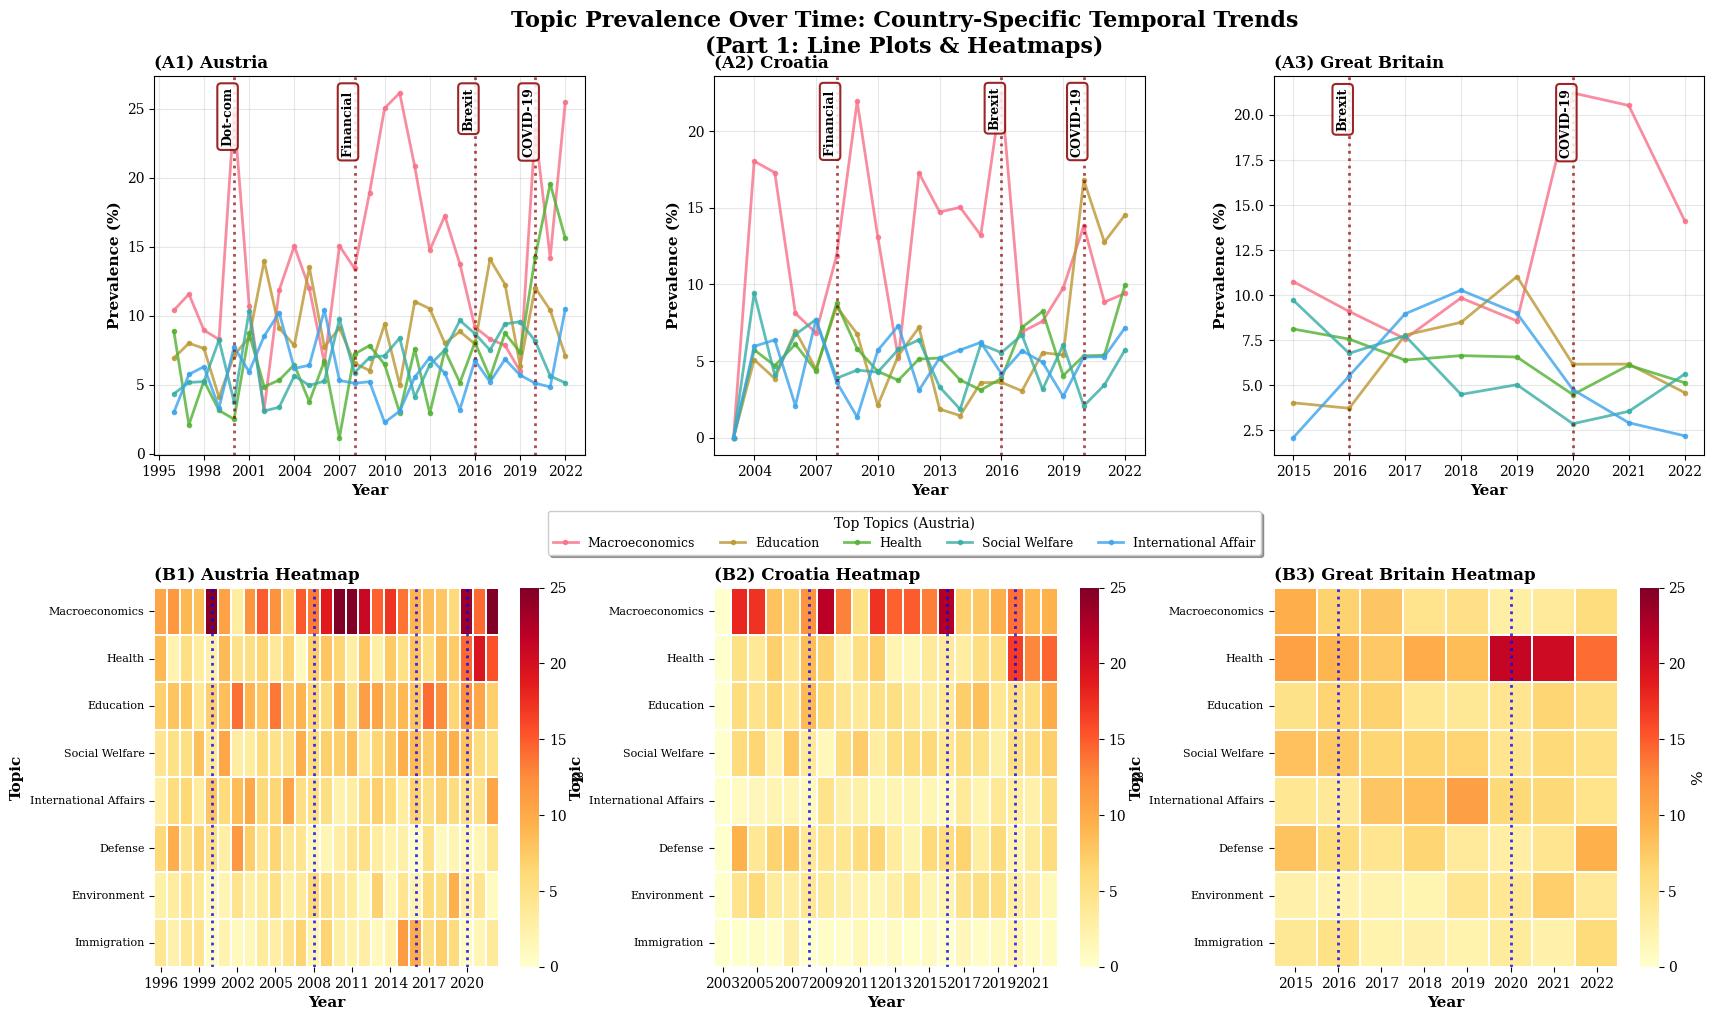

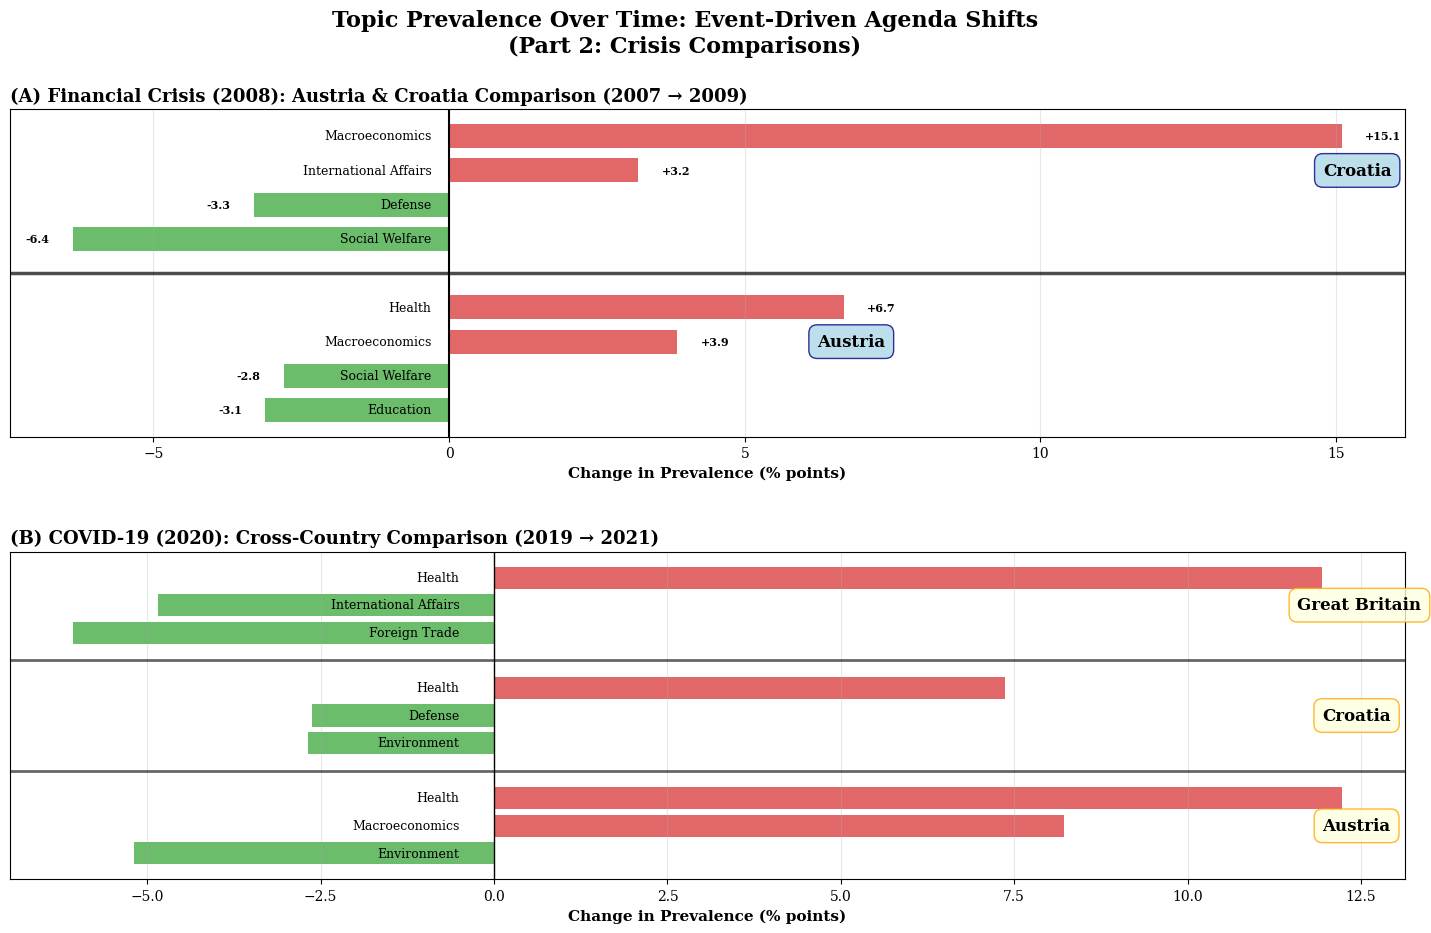


COUNTRY-SPECIFIC TOPIC SHIFTS

Austria:
  Most prevalent topic: Macroeconomics (14.2% avg)
  Trend: ↑ increasing (r=+0.255, n.s.)

Croatia:
  Most prevalent topic: Macroeconomics (12.1% avg)
  Trend: ↓ decreasing (r=-0.010, n.s.)

Great Britain:
  Most prevalent topic: Health (12.7% avg)
  Trend: ↑ increasing (r=+0.650, n.s.)


In [ ]:
# Topic Prevalence Temporal Analysis
topic_temporal_data = LIWC_ALL[LIWC_ALL['Year'].notna()].copy()

# Define key topics
key_topics = [
    'Macroeconomics', 'Health', 'Foreign Trade', 'Defense',
    'International Affairs', 'Education', 'Environment',
    'Energy', 'Immigration', 'Social Welfare'
]

# Calculate yearly topic proportions per country
country_yearly_topics = {}
for country in sorted(topic_temporal_data['Country'].unique()):
    country_data = topic_temporal_data[topic_temporal_data['Country'] == country]
    yearly_topic_data = country_data.groupby(['Year', 'Our_Topic']).size().unstack(fill_value=0)
    yearly_topic_props = yearly_topic_data.div(yearly_topic_data.sum(axis=1), axis=0) * 100
    
    available_topics = [t for t in key_topics if t in yearly_topic_props.columns]
    country_yearly_topics[country] = yearly_topic_props[available_topics]

# Define events
events_by_country = {
    'Austria': {2000: 'Dot-com', 2008: 'Financial Crisis', 2016: 'Brexit', 2020: 'COVID-19'},
    'Croatia': {2008: 'Financial Crisis', 2016: 'Brexit', 2020: 'COVID-19'},
    'Great Britain': {2016: 'Brexit', 2020: 'COVID-19'}
}

# ============================================================================
# FIGURE 1: TEMPORAL TRENDS & HEATMAPS (Rows A & B)
# ============================================================================

fig1 = plt.figure(figsize=(20, 11))
gs1 = fig1.add_gridspec(2, 3, hspace=0.35, wspace=0.3, top=0.92)

fig1.suptitle('Topic Prevalence Over Time: Country-Specific Temporal Trends\n(Part 1: Line Plots & Heatmaps)', 
            fontsize=16, fontweight='bold', y=0.98)

# ROW 1: Line plots for each country
countries = sorted(country_yearly_topics.keys())
all_lines = []
all_labels = []

for idx, country in enumerate(countries):
    ax = fig1.add_subplot(gs1[0, idx])
    
    yearly_props = country_yearly_topics[country]
    
    # Plot top 5 topics for this country
    top_topics_country = yearly_props.mean().nlargest(5).index
    
    for topic in top_topics_country:
        line, = ax.plot(yearly_props.index, yearly_props[topic], 
                       marker='o', linewidth=2, label=topic[:20], alpha=0.8, markersize=3)
        if idx == 0:
            all_lines.append(line)
            all_labels.append(topic[:20])
    
    # Add country-specific event markers
    events = events_by_country.get(country, {})
    for year, event in events.items():
        if year in yearly_props.index:
            ax.axvline(x=year, color='darkred', linestyle=':', alpha=0.7, linewidth=2)
            ax.text(year, ax.get_ylim()[1] * 0.97, event[:10], 
                   rotation=90, va='top', ha='right', 
                   fontsize=9, color='black', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                            edgecolor='darkred', alpha=0.85, linewidth=1.5))

    ax.set_xlabel('Year', fontweight='bold')
    ax.set_ylabel('Prevalence (%)', fontweight='bold')
    ax.set_title(f'(A{idx+1}) {country}', fontweight='bold', loc='left')
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=10))

# Add unified legend
fig1.legend(all_lines, all_labels, loc='upper center', bbox_to_anchor=(0.5, 0.53), 
          ncol=5, fontsize=9, frameon=True, fancybox=True, shadow=True,
          title='Top Topics (Austria)', title_fontsize=10)

# ROW 2: Heatmaps for each country
all_topics_by_prevalence = {}
for country in countries:
    yearly_props = country_yearly_topics[country]
    topic_means = yearly_props.mean()
    all_topics_by_prevalence[country] = topic_means

combined_prevalence = pd.concat(all_topics_by_prevalence.values()).groupby(level=0).mean()
global_top_topics = combined_prevalence.nlargest(10).index.tolist()

for idx, country in enumerate(countries):
    ax = fig1.add_subplot(gs1[1, idx])
    
    yearly_props = country_yearly_topics[country]
    
    # Use global top topics that exist in this country's data
    top_topics_hm = [t for t in global_top_topics if t in yearly_props.columns][:8]
    
    # Fill with country-specific topics if needed
    if len(top_topics_hm) < 8:
        country_specific = yearly_props.mean().nlargest(8).index.tolist()
        for topic in country_specific:
            if topic not in top_topics_hm:
                top_topics_hm.append(topic)
            if len(top_topics_hm) >= 8:
                break
    
    hm_data = yearly_props[top_topics_hm].T
    
    sns.heatmap(hm_data, cmap='YlOrRd', ax=ax, cbar_kws={'label': '%'}, 
               linewidths=0.3, annot=False, vmin=0, vmax=25)
    
    # Add event markers
    events = events_by_country.get(country, {})
    for year, event in events.items():
        if year in yearly_props.index:
            year_idx = list(yearly_props.index).index(year)
            ax.axvline(x=year_idx + 0.5, color='blue', linestyle=':', linewidth=2, alpha=0.8)
    
    ax.set_xlabel('Year', fontweight='bold')
    ax.set_ylabel('Topic', fontweight='bold')
    ax.set_title(f'(B{idx+1}) {country} Heatmap', fontweight='bold', loc='left')
    ax.set_yticklabels([t[:25] for t in top_topics_hm], fontsize=8)
    
    # Fix x-axis to show only whole years
    years_list = list(yearly_props.index)
    step = max(1, len(years_list) // 8)
    tick_positions = range(0, len(years_list), step)
    tick_labels = [int(years_list[i]) for i in tick_positions if i < len(years_list)]
    ax.set_xticks([i + 0.5 for i in tick_positions if i < len(years_list)])
    ax.set_xticklabels(tick_labels, rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(os.path.join(output_dir, 'fig_topic_prevalence_temporal_part1.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# FIGURE 2: EVENT COMPARISONS (Rows C & D)
# ============================================================================

fig2 = plt.figure(figsize=(18, 10))
gs2 = fig2.add_gridspec(2, 1, hspace=0.35)

fig2.suptitle('Topic Prevalence Over Time: Event-Driven Agenda Shifts\n(Part 2: Crisis Comparisons)', 
            fontsize=16, fontweight='bold')

# ROW 1: Financial Crisis 2008 (Austria & Croatia)
ax_crisis = fig2.add_subplot(gs2[0])

crisis_data = []
for country in ['Austria', 'Croatia']:
    yearly_props = country_yearly_topics[country]
    before = yearly_props.loc[2007]
    after = yearly_props.loc[2009]
    change = after - before
    
    top_changes = change.abs().nlargest(4)
    for topic in top_changes.index:
        crisis_data.append({
            'Country': country,
            'Topic': topic[:35],
            'Change': change[topic],
            'Before': before[topic],
            'After': after[topic]
        })
    
df_crisis = pd.DataFrame(crisis_data)

# Track y-positions for separator placement
all_y_positions = []

for i, country in enumerate(['Austria', 'Croatia']):
    country_crisis = df_crisis[df_crisis['Country'] == country].sort_values('Change')
    x_pos = i * 5 + np.arange(len(country_crisis))
    colors = ['#d62728' if x > 0 else '#2ca02c' for x in country_crisis['Change']]
    
    ax_crisis.barh(x_pos, country_crisis['Change'], color=colors, alpha=0.7, height=0.7)
    
    # Track positions
    all_y_positions.append((x_pos[0], x_pos[-1]))
    
    for j, (idx, row) in enumerate(country_crisis.iterrows()):
        y_pos = x_pos[j]
        ax_crisis.text(-0.3, y_pos, row['Topic'], ha='right', va='center', fontsize=9)
    
    # Country label
    mid_y = x_pos[len(x_pos)//2]
    ax_crisis.text(ax_crisis.get_xlim()[1] * 0.95, mid_y, country, 
                  ha='center', va='center', fontsize=12, fontweight='bold',
                  bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', 
                           edgecolor='navy', alpha=0.8))

# Draw separator between countries
austria_end = all_y_positions[0][1]
croatia_start = all_y_positions[1][0]
separator_y = (austria_end + croatia_start) / 2

ax_crisis.axhline(y=separator_y, color='black', linewidth=2.5, alpha=0.7)
ax_crisis.axvline(x=0, color='black', linewidth=1.5)
ax_crisis.set_xlabel('Change in Prevalence (% points)', fontweight='bold')
ax_crisis.set_title('(A) Financial Crisis (2008): Austria & Croatia Comparison (2007 → 2009)', 
                   fontweight='bold', loc='left', fontsize=13)
ax_crisis.set_yticks([])
ax_crisis.grid(True, alpha=0.3, axis='x')

# Value labels
for i, country in enumerate(['Austria', 'Croatia']):
    country_crisis = df_crisis[df_crisis['Country'] == country].sort_values('Change')
    x_pos = i * 5 + np.arange(len(country_crisis))
    
    for j, (idx, row) in enumerate(country_crisis.iterrows()):
        if abs(row['Change']) > 1.0:
            x_val = row['Change'] + (0.4 if row['Change'] > 0 else -0.4)
            ax_crisis.text(x_val, x_pos[j], f'{row["Change"]:+.1f}', va='center', 
                          ha='left' if row['Change'] > 0 else 'right', 
                          fontsize=8, fontweight='bold')

# ROW 2: COVID-19 2020 (All three countries)
ax_covid = fig2.add_subplot(gs2[1])

covid_data = []
for country in countries:
    yearly_props = country_yearly_topics[country]
    before = yearly_props.loc[2019]
    after = yearly_props.loc[2021]
    change = after - before
    
    top_changes = change.abs().nlargest(3)
    for topic in top_changes.index:
        covid_data.append({
            'Country': country,
            'Topic': topic[:30],
            'Change': change[topic]
        })

df_covid = pd.DataFrame(covid_data)

# Track y-positions for separator placement
country_y_ranges = []

for i, country in enumerate(countries):
    country_covid = df_covid[df_covid['Country'] == country].sort_values('Change')
    x_pos = i * 4 + np.arange(len(country_covid))
    colors = ['#d62728' if x > 0 else '#2ca02c' for x in country_covid['Change']]
    
    ax_covid.barh(x_pos, country_covid['Change'], color=colors, alpha=0.7, height=0.8)
    
    # Track positions
    country_y_ranges.append((x_pos[0], x_pos[-1]))
    
    # Topic labels
    for j, (idx, row) in enumerate(country_covid.iterrows()):
        y_pos = x_pos[j]
        ax_covid.text(-0.5, y_pos, row['Topic'], ha='right', va='center', fontsize=9)
    
    # Country label
    mid_y = x_pos[len(x_pos)//2]
    ax_covid.text(ax_covid.get_xlim()[1] * 0.95, mid_y, country, 
                 ha='center', va='center', fontsize=12, fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', 
                          edgecolor='orange', alpha=0.8))

# Draw separators between country groups
for i in range(len(country_y_ranges) - 1):
    prev_end = country_y_ranges[i][1]
    next_start = country_y_ranges[i + 1][0]
    separator_y = (prev_end + next_start) / 2
    
    ax_covid.axhline(y=separator_y, color='black', linewidth=2, alpha=0.6)

ax_covid.axvline(x=0, color='black', linewidth=1)
ax_covid.set_xlabel('Change in Prevalence (% points)', fontweight='bold')
ax_covid.set_title('(B) COVID-19 (2020): Cross-Country Comparison (2019 → 2021)', 
                  fontweight='bold', loc='left', fontsize=13)
ax_covid.set_yticks([])
ax_covid.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'fig_topic_prevalence_temporal_part2.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

# Statistical summary
print("\n" + "="*60)
print("COUNTRY-SPECIFIC TOPIC SHIFTS")
print("="*60)

for country in countries:
    print(f"\n{country}:")
    yearly_props = country_yearly_topics[country]
    
    # Most prevalent topic
    overall_prev = yearly_props.mean()
    top_topic = overall_prev.idxmax()
    print(f"  Most prevalent topic: {top_topic} ({overall_prev[top_topic]:.1f}% avg)")
    
    # Temporal trend for top topic
    r, p = pearsonr(yearly_props.index, yearly_props[top_topic])
    trend = "↑ increasing" if r > 0 else "↓ decreasing"
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "n.s."
    print(f"  Trend: {trend} (r={r:+.3f}, {sig})")

## 8. Embedding Translation Quality Analysis

In [ ]:
# # Embedding Translation Quality Analysis
# def analyze_embedding_translation_quality():
#     """
#     Analyze the quality of embeddings by comparing English vs native language versions
#     for Austria and Croatia datasets. Measures cosine similarity and its relationship with text length.
#     """
#     from sklearn.metrics.pairwise import cosine_similarity
    
#     print("="*60)
#     print("EMBEDDING TRANSLATION QUALITY ANALYSIS")
#     print("="*60)
    
#     # Load AT and HR data with embeddings (already loaded with LIWC data merged)
#     AT = pd.read_pickle(AT_path)
#     HR = pd.read_pickle(HR_path)
    
#     # Merge with LIWC data to get WC column
#     AT_LIWC_data = pd.read_csv(AT_path_LIWC)
#     HR_LIWC_data = pd.read_csv(HR_path_LIWC)
    
#     AT = pd.merge(AT, AT_LIWC_data[['ID', 'WC']], on='ID', how='inner')
#     HR = pd.merge(HR, HR_LIWC_data[['ID', 'WC']], on='ID', how='inner')
    
#     # Check if embedding columns exist
#     required_cols = ['Speech_Embeddings_english', 'Speech_Embeddings_native_language']
    
#     embedding_results = []
    
#     for country, data in [('Austria', AT), ('Croatia', HR)]:
#         if all(col in data.columns for col in required_cols):
#             # Filter valid embeddings
#             valid_data = data[data[required_cols].notna().all(axis=1)].copy()
            
#             print(f"\n{country}:")
#             print(f"  Valid embedding pairs: {len(valid_data):,}")
            
#             if len(valid_data) > 0:
#                 # Calculate cosine similarities
#                 similarities = []
#                 for idx, row in valid_data.iterrows():
#                     emb_en = np.array(row['Speech_Embeddings_english']).reshape(1, -1)
#                     emb_native = np.array(row['Speech_Embeddings_native_language']).reshape(1, -1)
#                     sim = cosine_similarity(emb_en, emb_native)[0, 0]
#                     similarities.append(sim)
                
#                 valid_data['Embedding_Similarity'] = similarities
                
#                 # Use WC (word count) from LIWC data
#                 valid_data['Text_Length'] = valid_data['WC']
#                 print(f"  Using WC (word count) from LIWC analysis for text length")
                
#                 # Print summary statistics
#                 print(f"  Mean cosine similarity: {np.mean(similarities):.4f}")
#                 print(f"  Std deviation: {np.std(similarities):.4f}")
#                 print(f"  Min similarity: {np.min(similarities):.4f}")
#                 print(f"  Max similarity: {np.max(similarities):.4f}")
                
#                 # Correlation with text length
#                 if 'Text_Length' in valid_data.columns:
#                     corr, p_val = pearsonr(valid_data['Embedding_Similarity'], valid_data['Text_Length'])
#                     print(f"  Correlation with text length: r={corr:.3f}, p={p_val:.4f}")
                
#                 # Store results
#                 embedding_results.append({
#                     'Country': country,
#                     'Data': valid_data,
#                     'Mean_Similarity': np.mean(similarities),
#                     'Std_Similarity': np.std(similarities),
#                     'Min_Similarity': np.min(similarities),
#                     'Max_Similarity': np.max(similarities)
#                 })
#             else:
#                 print(f"  No valid embedding pairs found")
#         else:
#             print(f"\n{country}: Embedding columns not found")
    
#     # Visualization only
#     if len(embedding_results) > 0:
#         fig, axes = plt.subplots(2, 2, figsize=(16, 12))
#         fig.suptitle('Embedding Translation Quality: English vs Native Language', 
#                     fontsize=16, fontweight='bold')
        
#         # Plot 1: Distribution of similarities
#         ax = axes[0, 0]
#         for result in embedding_results:
#             data = result['Data']
#             ax.hist(data['Embedding_Similarity'], bins=50, alpha=0.6, 
#                    label=result['Country'], edgecolor='black')
#         ax.set_xlabel('Cosine Similarity')
#         ax.set_ylabel('Frequency')
#         ax.set_title('Distribution of Embedding Similarities', fontweight='bold')
#         ax.legend(loc='upper left')
       

#         ax.grid(True, alpha=0.3)
        
#         # Plot 2: Box plot comparison
#         ax = axes[0, 1]
#         box_data = [result['Data']['Embedding_Similarity'] for result in embedding_results]
#         box_labels = [result['Country'] for result in embedding_results]
#         bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)
#         for patch, color in zip(bp['boxes'], ['#ff7f0e', '#2ca02c']):
#             patch.set_facecolor(color)
#             patch.set_alpha(0.7)
#         ax.set_ylabel('Cosine Similarity')
#         ax.set_title('Embedding Similarity by Country', fontweight='bold')
#         ax.grid(True, alpha=0.3, axis='y')
#         ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.7)
        
#         # Plot 3 & 4: Scatter plots - Similarity vs Text Length (LOG SCALE)
#         for idx, result in enumerate(embedding_results):
#             ax = axes[1, idx]
#             data = result['Data']
            
#             # Use ALL data points without sampling
#             scatter = ax.scatter(data['Text_Length'], 
#                                data['Embedding_Similarity'],
#                                alpha=0.3, s=20, c=data['Embedding_Similarity'],
#                                cmap='viridis', edgecolors='none')
            
#             # Use log scale for x-axis with minimum at 10 words
#             ax.set_xscale('log')
#             x_min = max(10, data['Text_Length'].min())
#             x_max = data['Text_Length'].max()
#             ax.set_xlim(x_min, x_max * 1.1)
            
#             # Set y-axis limits with padding
#             y_min = data['Embedding_Similarity'].min()
#             y_max = data['Embedding_Similarity'].max()
#             y_range = y_max - y_min
#             ax.set_ylim(y_min - y_range * 0.05, y_max + y_range * 0.05)
            
#             ax.set_xlabel('Text Length (words, log scale)', fontweight='bold')
#             ax.set_ylabel('Cosine Similarity (English vs Native)', fontweight='bold')
#             ax.set_title(f'Text Length vs Embedding Similarity (N={len(data):,})', fontweight='bold')
#             ax.grid(True, alpha=0.3)
            
#             # Add colorbar
#             cbar = plt.colorbar(scatter, ax=ax)
#             cbar.set_label('Similarity', rotation=270, labelpad=20, fontweight='bold')
            
#             # Add correlation annotation
#             corr, p_val = pearsonr(data['Embedding_Similarity'], data['Text_Length'])
#             corr_text = f'Pearson r = {corr:.4f}\np-value = {p_val:.4e}\nText length range:\n{data["Text_Length"].min():.0f} - {x_max:.0f} words'
#             ax.text(0.05, 0.95, corr_text, transform=ax.transAxes, 
#                     verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
#                     fontsize=10)
        
#         plt.tight_layout()
#         plt.savefig(os.path.join(output_dir, 'embedding_translation_quality.png'), 
#                    dpi=300, bbox_inches='tight')
#         plt.show()
        
#         # Summary table for paper
#         print("\n" + "="*60)
#         print("SUMMARY TABLE FOR PAPER")
#         print("="*60)
#         summary_df = pd.DataFrame([{
#             'Country': r['Country'],
#             'N': len(r['Data']),
#             'Mean Similarity': f"{r['Mean_Similarity']:.4f}",
#             'SD': f"{r['Std_Similarity']:.4f}",
#             'Range': f"[{r['Min_Similarity']:.4f}, {r['Max_Similarity']:.4f}]",
#             'Corr w/ Length': f"{pearsonr(r['Data']['Embedding_Similarity'], r['Data']['Text_Length'])[0]:.3f}"
#         } for r in embedding_results])
        
#         print(summary_df.to_string(index=False))
        
#         # Quality assessment
#         print("\n" + "="*60)
#         print("EMBEDDING QUALITY ASSESSMENT")
#         print("="*60)
        
#         for result in embedding_results:
#             high_quality = (result['Data']['Embedding_Similarity'] >= 0.9).sum()
#             medium_quality = ((result['Data']['Embedding_Similarity'] >= 0.8) & 
#                             (result['Data']['Embedding_Similarity'] < 0.9)).sum()
#             low_quality = (result['Data']['Embedding_Similarity'] < 0.8).sum()
            
#             total = len(result['Data'])
            
#             print(f"\n{result['Country']}:")
#             print(f"  High quality (≥0.9): {high_quality:,} ({high_quality/total*100:.1f}%)")
#             print(f"  Medium quality (0.8-0.9): {medium_quality:,} ({medium_quality/total*100:.1f}%)")
#             print(f"  Low quality (<0.8): {low_quality:,} ({low_quality/total*100:.1f}%)")
        
#         return embedding_results
#     else:
#         print("\nNo embedding data available for analysis")
#         return None

# # Run the embedding quality analysis
# embedding_quality_results = analyze_embedding_translation_quality()

In [ ]:
# # Detailed visualization for each country: Histogram + Scatter plot
# if embedding_quality_results:
#     for result in embedding_quality_results:
#         country = result['Country']
#         data = result['Data']
        
#         # Create figure with 2 subplots
#         fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#         fig.suptitle(f'{country}: Embedding Translation Quality Analysis', 
#                     fontsize=16, fontweight='bold')
        
#         # Plot 1: Histogram of cosine similarities
#         ax1 = axes[0]
#         ax1.hist(data['Embedding_Similarity'], bins=50, alpha=0.7, 
#                 color='steelblue', edgecolor='black')
#         ax1.axvline(x=data['Embedding_Similarity'].mean(), color='red', 
#                    linestyle='--', linewidth=2, label=f'Mean: {data["Embedding_Similarity"].mean():.3f}')
#         ax1.axvline(x=data['Embedding_Similarity'].median(), color='green', 
#                    linestyle='--', linewidth=2, label=f'Median: {data["Embedding_Similarity"].median():.3f}')
#         ax1.set_xlabel('Cosine Similarity (English vs Native)', fontweight='bold')
#         ax1.set_ylabel('Frequency', fontweight='bold')
#         ax1.set_title('Distribution of Embedding Similarities', fontweight='bold')
#         ax1.legend(loc='upper left')
#         ax1.grid(True, alpha=0.3)
        
#         # Plot 2: Scatter plot - Text Length vs Cosine Similarity (ALL data points with LOG SCALE)
#         ax2 = axes[1]
        
#         # Use ALL data points without sampling
#         scatter = ax2.scatter(data['Text_Length'], 
#                             data['Embedding_Similarity'],
#                             alpha=0.3, s=20, c=data['Embedding_Similarity'],
#                             cmap='viridis', edgecolors='none')
            
#         # Use log scale for x-axis with minimum at 10 words
#         ax2.set_xscale('log')
#         x_min = max(10, data['Text_Length'].min())
#         x_max = data['Text_Length'].max()
#         ax2.set_xlim(x_min, x_max * 1.1)
        
#         # Set y-axis limits with padding
#         y_min = data['Embedding_Similarity'].min()
#         y_max = data['Embedding_Similarity'].max()
#         y_range = y_max - y_min
#         ax2.set_ylim(y_min - y_range * 0.05, y_max + y_range * 0.05)
            
#         ax2.set_xlabel('Text Length (words, log scale)', fontweight='bold')
#         ax2.set_ylabel('Cosine Similarity (English vs Native)', fontweight='bold')
#         ax2.set_title(f'Text Length vs Embedding Similarity (N={len(data):,})', fontweight='bold')
#         ax2.grid(True, alpha=0.3)
        
#         # Add colorbar
#         cbar = plt.colorbar(scatter, ax=ax2)
#         cbar.set_label('Similarity', rotation=270, labelpad=20, fontweight='bold')
        
#         # Add correlation annotation
#         corr, p_val = pearsonr(data['Embedding_Similarity'], data['Text_Length'])
#         corr_text = f'Pearson r = {corr:.4f}\np-value = {p_val:.4e}\nText length range:\n{data["Text_Length"].min():.0f} - {x_max:.0f} words'
#         ax2.text(0.05, 0.95, corr_text, transform=ax2.transAxes, 
#                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
#                 fontsize=10)
        
#         plt.tight_layout()
        
#         # Save figure
#         filename = f'embedding_quality_{country.lower().replace(" ", "_")}.png'
#         plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
#         print(f"Saved: {filename}")
        
#         plt.show()
        
#         # Print detailed statistics for this country
#         print(f"\n{'='*60}")
#         print(f"{country.upper()} - DETAILED STATISTICS")
#         print(f"{'='*60}")
#         print(f"Total embedding pairs: {len(data):,}")

#         print(f"Text length range: {data['Text_Length'].min():.0f} - {data['Text_Length'].max():.0f} words")
#         print(f"Mean similarity: {data['Embedding_Similarity'].mean():.4f}")
#         print(f"Median similarity: {data['Embedding_Similarity'].median():.4f}")
#         print(f"Std deviation: {data['Embedding_Similarity'].std():.4f}")
#         print(f"Min similarity: {data['Embedding_Similarity'].min():.4f}")
#         print(f"Max similarity: {data['Embedding_Similarity'].max():.4f}")
#         print(f"\nCorrelation with text length:")
#         print(f"  Pearson r = {corr:.4f}")

# else:
#     print("No embedding quality results available for visualization")